Load extracted table of datasets from http://projects.sanderlab.org/scperturb/datavzrd/scPerturb_vzrd_v1/dataset_info/index_1.html#

(And add imports)

In [1]:
import pandas as pd
from src import utils
import os
import numpy as np
os.chdir('../')
datasets = pd.read_csv('resources/config_prep/datasets.csv')

Check file sizes of each dataset

In [2]:
urls = datasets['Download Link'].tolist()
# calculate file size and add human-readable size
datasets['bytes'] = [utils.get_file_size(url, verbose=True) for url in urls]
datasets['size'] = datasets['bytes'].apply(utils.convert_size)

Checking file size of https://zenodo.org/record/7041849/files/AdamsonWeissman2016_GSM2406675_10X001.h5ad: 34557246
Checking file size of https://zenodo.org/record/7041849/files/AdamsonWeissman2016_GSM2406677_10X005.h5ad: 139059637
Checking file size of https://zenodo.org/record/7041849/files/AdamsonWeissman2016_ GSM2406681_10X010.h5ad: None
Checking file size of https://zenodo.org/record/7041849/files/AissaBenevolenskaya2021.h5ad: 45919115
Checking file size of https://zenodo.org/record/7041849/files/ChangYe2021.h5ad: 501823050
Checking file size of https://zenodo.org/record/7041849/files/DatlingerBock2017.h5ad: 39085166
Checking file size of https://zenodo.org/record/7041849/files/DatlingerBock2021.h5ad: 33600780
Checking file size of https://zenodo.org/record/7041849/files/DixitRegev2016.h5ad: 309282071
Checking file size of https://zenodo.org/record/7041849/files/FrangiehIzar2021_RNA.h5ad: 1458928348
Checking file size of https://zenodo.org/record/7041849/files/FrangiehIzar2021_prot

Save changes to dataset.csv

In [3]:
datasets.to_csv('resources/config_prep/datasets.csv', index=False)

Add extra data from downloadable excel sheet (also from same page)

In [4]:
e_data = pd.read_excel('resources/config_prep/data.xlsx', sheet_name='dataset_info')

In [5]:
# unify columns
datasets.columns = datasets.columns.str.lower()
e_data.columns = e_data.columns.str.lower()

In [6]:
# drop duplicated columns in e_data not needed for merge
e_data.drop(columns=['download link', 'full index', 'title', 'doi_url', 'first author'], inplace=True)

In [7]:
# merge data and save to dataset.csv
merged = datasets.merge(e_data, on=['publication index', 'dataset index'], how='left')
print(f"{np.abs(merged.shape[0] - datasets.shape[0])} datasets lost on merge")

0 datasets lost on merge


In [9]:
merged.to_csv('resources/datasets/templates/datasets.csv', index=False)

Filter datasets that we would like to include

In [80]:
# focus on pure RNA datasets
filtered_ds = merged[merged['modality'] == 'RNA']
# only use CRISPR perturbations, exclude things like drugs or cytokines, etc.
filtered_ds = filtered_ds[filtered_ds['perturbation'].str.startswith('CRISPR')]
# exclude non-functional links (i.e., with -1 byte size)
filtered_ds = filtered_ds[filtered_ds['bytes']!=-1]

In [81]:
# some numbers of perturbations are given as combinations, so take the square rook to make them comparable
comb_mask = filtered_ds['number of perturbations'].str.endswith('combinations)')
filtered_ds.loc[comb_mask, 'number of perturbations'] = np.round(np.sqrt(filtered_ds[comb_mask]['number of perturbations'].str.split(" ").map(lambda s: int(s[0])))).astype(int)
filtered_ds['number of perturbations'] = filtered_ds['number of perturbations'].astype(int)

In [82]:
import seaborn as sns
from matplotlib import pyplot as plt

Meta-set spans 20 perturb-seq-like datasets
Number of total (non-unique) perturbations: 23146
Perturbation protocols: ['CRISPRi' 'CRISPR-cas9, TCR stim' 'CRISPR-cas9' 'CRISPRa']
Sequence protocols: ['Perturb-seq' 'CROP-seq' 'scifi-RNA-seq (derived from CROP-seq)'
 'TAP-seq' 'Mosaic-seq']


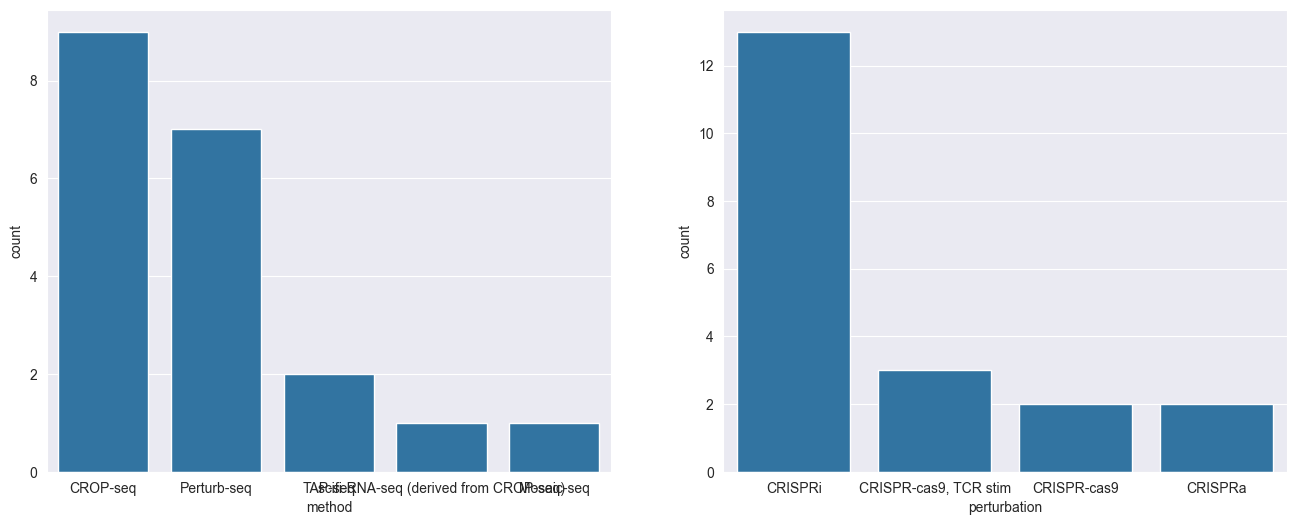

In [83]:
print(f'Meta-set spans {filtered_ds.shape[0]} perturb-seq-like datasets')
# unify perturbations column to integer
num_pert = filtered_ds['number of perturbations'].sum()
print(f'Number of total (non-unique) perturbations: {num_pert}')
pert = filtered_ds['perturbation'].unique()
print(f'Perturbation protocols: {pert}')
seqs = filtered_ds['method'].unique()
print(f'Sequence protocols: {seqs}')
# count occurrence of perturbation types and sequencing methods
method_counts = filtered_ds['method'].value_counts().reset_index()
pert_counts = filtered_ds['perturbation'].value_counts().reset_index()
# bar plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.barplot(x='method', y='count', data=method_counts, ax=axes[0])
sns.barplot(x='perturbation', y='count', data=pert_counts, ax=axes[1])
plt.show()

In [85]:
# save to templates
filtered_ds.to_csv('resources/datasets/meta/filtered_datasets.csv', index=False)

Add datasets to config.yaml

In [94]:
index = filtered_ds['publication index'].str.cat(filtered_ds['dataset index'], sep='_', na_rep='').str.rstrip("_")
filtered_ds['index'] = index

In [95]:
# remove any white spaces from links
filtered_ds['download link'] = filtered_ds['download link'].str.replace(' ', '')
with open('config/config.yaml', 'a') as f:
    f.write('\ndatasets:\n')
    for i, row in filtered_ds[['index', 'download link']].iterrows():
        f.write(f"- \"{row['index']}\": \"{row['download link']}\"\n")